In [21]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths


import pandas as pd

from src.utils import plot_confusion_matrix,  ms_label2id

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

# Llama2-MedTuned-13B

## Zero Shot

Following an instruction tuning approach, as the MedTuned model was finetuned using an instruction dataset (Rohanian et al. 2023). The template looks as follows:

```python
"<s>[INST]### Instruction: {instruction} ### Input: {user_input} ### Output: [/INST]"
```
instruction:
"Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "primär progrediente Multiple Sklerose (PPMS), sekundär progrediente Multiple Sklerose (SPMS) and schubförmige Multiple Sklerose (RRMS). The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with "not enough info".Your answer should solely consist of either "primär progrediente Multiple Sklerose (PPMS)", "sekundär progrediente Multiple Sklerose (SPMS)", "schubförmige Multiple Sklerose (RRMS)", or "not enough info. Here is the medical report: "

user_input: the medical report to be processed

I will compare single line classification, full report classification and a variation of full report classification putting the diagnosis last.
                   

### Line-Level

In [22]:
results_line = pd.read_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_line_paper-prompt_all.csv", index_col=0)

In [23]:
# Count of how many do not explicitly follow the desired output format, I will allow for lowercase and strip
allowed_fomats = ["primär progrediente multiple sklerose (ppms)", 
                  "sekundär progrediente multiple sklerose (spms)",
                  "schubförmige multiple sklerose (rrms)"]

# Function to check for exact matches
def check_exact_match(series, allowed_formats):
    """
    Check if each value in the Pandas Series exactly matches one of the allowed formats.

    Parameters:
    - series: Pandas Series
    - allowed_formats: List of allowed formats

    Returns:
    - A boolean mask indicating whether each value exactly matches one of the allowed formats.
    """
    return series.apply(lambda x: any(str(x).lower() == allowed_format.lower() for allowed_format in allowed_formats))

# Remapping it to labels using keyword mapping
label_mapping = {
    'ppms': 'primary_progressive_multiple_sclerosis',
    'primär': 'primary_progressive_multiple_sclerosis',
    'sekundär': 'secondary_progressive_multiple_sclerosis',
    'spms': 'secondary_progressive_multiple_sclerosis',
    'rrms': 'relapsing_remitting_multiple_sclerosis',
    'schubförmig': 'relapsing_remitting_multiple_sclerosis',
    'not enough info': 'no_ms'
}

def map_strings_to_labels(input_string):
    """
    Map a string to a label using a keyword mapping. If more than one keyword is found, the first one is used.

    Parameters:
    - input_string: String to map to a label

    Returns:
    - The mapped label
    """
    
    input_lower = str(input_string).strip().lower()
    
    first_match_key = None
    first_match_index = float('inf')  # Set to positive infinity initially
    
    for key in label_mapping.keys():
        index = input_lower.find(key)
        if index != -1 and index < first_match_index:
            first_match_key = key
            first_match_index = index
    label = label_mapping.get(first_match_key, None) if first_match_key else None
    return ms_label2id.get(label, -99)

def zero_shot_report(file_name):
    """
    Print a report for the zero-shot classification task.

    Parameters:
    - results: File name of the results file. Must have columns "labels" and "result".
    """

    results = pd.read_csv(paths.RESULTS_PATH/"ms-diag"/file_name, index_col=0)
    
    # Cast result column to string
    results.result = results.result.astype(str)

    # Exact match
    exact_match = check_exact_match(results.result, allowed_fomats)
    print("Exact match percentage: ", sum(exact_match)/len(results))

    # Remap to labels
    results.preds = results.result.apply(map_strings_to_labels)
    print("No matches: ", sum(results.preds==-99))

    # Print classification report
    print(classification_report(y_true=results.labels, y_pred=results.preds, target_names=["no_match"] + list(ms_label2id.keys())))

    # Plot confusion matrix
    plot_confusion_matrix(labels=results.labels, preds=results.preds)


Exact match percentage:  0.08552817898612292
No matches:  192
                                          precision    recall  f1-score   support

                                no_match       0.00      0.00      0.00         0
  primary_progressive_multiple_sclerosis       0.02      1.00      0.04        13
  relapsing_remitting_multiple_sclerosis       0.82      0.89      0.86       131
secondary_progressive_multiple_sclerosis       0.62      1.00      0.76         8
                                   no_ms       1.00      0.76      0.86      3379

                                accuracy                           0.76      3531
                               macro avg       0.49      0.73      0.50      3531
                            weighted avg       0.99      0.76      0.86      3531



/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


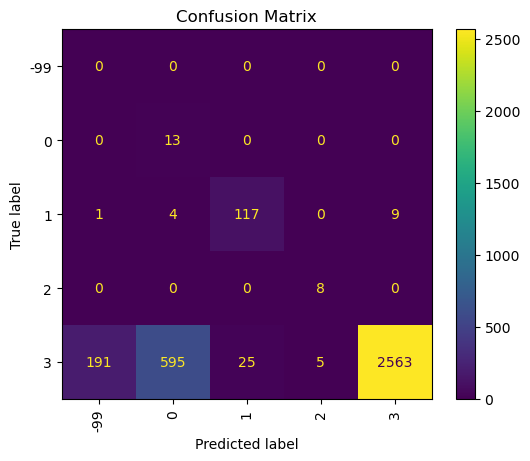

In [24]:
zero_shot_report("ms-diag_llama2-MedTuned_clm_line_paper-prompt_all.csv")

Exact match percentage:  0.46113989637305697
No matches:  1
                                          precision    recall  f1-score   support

                                no_match       0.00      0.00      0.00         0
  primary_progressive_multiple_sclerosis       0.32      1.00      0.48        13
  relapsing_remitting_multiple_sclerosis       0.99      0.77      0.87       131
secondary_progressive_multiple_sclerosis       0.67      0.50      0.57         8
                                   no_ms       0.86      0.90      0.88        41

                                accuracy                           0.80       193
                               macro avg       0.57      0.63      0.56       193
                            weighted avg       0.90      0.80      0.83       193



/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


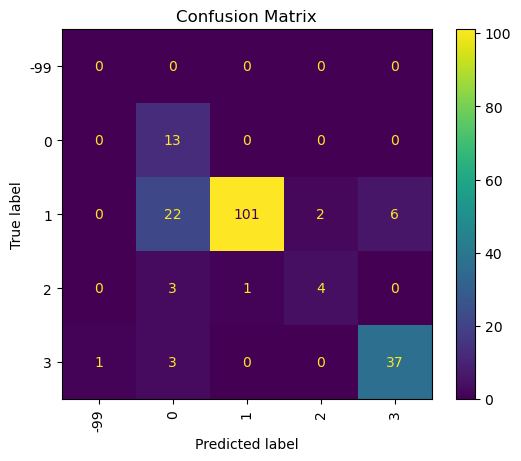

In [25]:
zero_shot_report("ms-diag_llama2-MedTuned_clm_all_paper-prompt_all.csv")

The difference in exact matches is because there are not as many reports, and especially not as many "no-info" reports.

Exact match percentage:  0.5181347150259067
No matches:  3
                                          precision    recall  f1-score   support

                                no_match       0.00      0.00      0.00         0
  primary_progressive_multiple_sclerosis       0.33      0.92      0.49        13
  relapsing_remitting_multiple_sclerosis       0.99      0.84      0.91       131
secondary_progressive_multiple_sclerosis       0.57      0.50      0.53         8
                                   no_ms       0.92      0.80      0.86        41

                                accuracy                           0.82       193
                               macro avg       0.56      0.61      0.56       193
                            weighted avg       0.91      0.82      0.85       193



/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


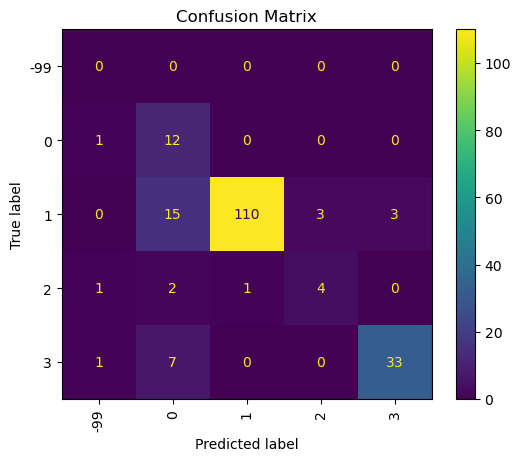

In [26]:
zero_shot_report("ms-diag_llama2-MedTuned_clm_first-last_paper-prompt_all.csv")

### Intermezzo: Sequence length and accuracy

In [27]:
# Log regression to find out input len and probability of correct classification
results_all = pd.read_csv(paths.RESULTS_PATH/"ms-diag"/"ms-diag_llama2-MedTuned_clm_all_paper-prompt_all.csv", index_col=0)
y = (results_all.labels == results_all.preds).astype(int)
X = results_all.input_len

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X.values.reshape(-1, 1), y.values)

print(clf.coef_)

[[-0.00029437]]
